In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter

import joblib
import matplotlib.pyplot as plt

from pytrends.request import TrendReq
import pytz

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLagabsolute_errorgingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope


In [25]:
SYMBOL= 'ETH'
df = loadFromDB(SYMBOL,'1h')
df_BTC = loadFromDB('BTC','1h')
df_BTC.head()

Total records : 42720 rows
Total records : 42720 rows


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800


In [3]:
pytrends = TrendReq(hl='fr-FR', tz=360) 
kw_list = ["BTC","Blockchain","Bitcoin"] # list of keywords to get data 

pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 
gtrends_data = pytrends.get_historical_interest(kw_list,
                                        year_start=df_BTC.index[0].year,
                                        month_start=df_BTC.index[0].month,
                                        day_start=df_BTC.index[0].day,
                                        hour_start=df_BTC.index[0].hour,
                                        year_end=df.index[-1].year,
                                        month_end=df_BTC.index[-1].month,
                                        day_end=df_BTC.index[-1].day,
                                        hour_end=df_BTC.index[-1].hour,
                                        cat=0, sleep=5,frequency='hourly')
def addTimestampToDf(df)->pd.DataFrame:
    """add timestamp to dataframe as column

    Args:
        df (pd.DataFrame): The Dataframe we want to add timestamp as col

    Returns:
        pd.DataFrame: The Dataframe with the new column
    """
    df['Timestamp'] = [round(datetime.timestamp(df.index[ind])) for ind in range(len(df.index))]
    df['Timestamp'] = df['Timestamp'].astype(int)
    return df
gtrends_data = addTimestampToDf(gtrends_data)

gtrends_data = gtrends_data.drop_duplicates(subset=['Timestamp'],keep='first')
print(len(gtrends_data))
gtrends_data['BTC'] = gtrends_data.apply(lambda x: x['BTC']+x['Bitcoin']+x['Blockchain'], axis=1)
gtrends_data.drop(columns=['Bitcoin','isPartial','Blockchain'], inplace=True)
gtrends_data.head()

42841


,BTC,Timestamp
date,,
2017-08-17 06:00:00,111,1502942400
2017-08-17 07:00:00,114,1502946000
2017-08-17 08:00:00,107,1502949600
2017-08-17 09:00:00,103,1502953200
2017-08-17 10:00:00,105,1502956800


In [4]:
backup_g_trend = gtrends_data.copy()

In [5]:
def removeMissingData(left_df:pd.DataFrame,right_df:pd.DataFrame,left_key:str,right_key:str,mode:str='inner'):
    """remove missing data from left and right dataframe
    """
    if mode=='inner':
        excess_left = list(set(left_df[left_key].values) - set(right_df[right_key].values))
        for i in excess_left:
            left_df.drop(left_df.loc[left_df[left_key]==i].index, inplace=True)
            
        excess_right = list(set(right_df[right_key].values)-set(left_df[left_key].values))
        for i in excess_right:
            right_df.drop(right_df.loc[right_df[right_key]==i].index, inplace=True)    
        return left_df,right_df
    elif mode=='right':
        excess_right = list(set(right_df[right_key].values)-set(left_df[left_key].values))
        for i in excess_right:
            right_df.drop(right_df.loc[right_df[right_key]==i].index, inplace=True)   
        return left_df,right_df
    elif mode=='left':
        excess_left = list(set(left_df[left_key].values) - set(right_df[right_key].values))
        for i in excess_left:
            left_df.drop(left_df.loc[left_df[left_key]==i].index, inplace=True)
        return left_df,right_df
    else:
        print('Error wrong mode...')
        return 0

In [6]:
df_BTC,gtrends_data = removeMissingData(df_BTC,gtrends_data,'Timestamp','Timestamp')
print(len(df_BTC))
print(len(gtrends_data))

42667
42667


In [7]:
df_BTC['G_trend'] = gtrends_data['BTC']
df_BTC.head()

,Open,High,Low,Close,Volume,Timestamp,G_trend
Date,,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400,111.0
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000,114.0
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600,107.0
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200,103.0
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800,105.0


In [8]:
import requests
import json
response_fng = requests.get('https://api.alternative.me/fng/?limit=0&format=json').text
df_fng = pd.DataFrame(json.loads(response_fng)['data'])
df_fng.drop(columns=['time_until_update'],inplace=True)
df_fng.rename(columns={'timestamp':'date'},inplace=True)
df_fng['date'] = df_fng['date'].astype(int).apply(lambda x: datetime.fromtimestamp(x))
df_fng.sort_values('date',inplace=True)
df_fng.set_index('date',inplace=True)
print(f'{len(df_fng)} total records')
df_fng.tail()

1615 total records


,value,value_classification
date,,
2022-07-03 02:00:00,11,Extreme Fear
2022-07-04 02:00:00,14,Extreme Fear
2022-07-05 02:00:00,19,Extreme Fear
2022-07-06 02:00:00,18,Extreme Fear
2022-07-07 02:00:00,18,Extreme Fear


In [9]:
def addFNG(x):
    try:
        return int(df_fng.loc[pd.to_datetime(x.name).date().strftime("%Y-%m-%d")].value.values[0])
    except:
        return np.nan
df_BTC['FnG'] = df_BTC.apply(addFNG,axis=1)

In [10]:
df_BTC.head()

,Open,High,Low,Close,Volume,Timestamp,G_trend,FnG
Date,,,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400,111.0,NaN
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000,114.0,NaN
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600,107.0,NaN
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200,103.0,NaN
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800,105.0,NaN


In [11]:
df_BTC.dropna()

,Open,High,Low,Close,Volume,Timestamp,G_trend,FnG
Date,,,,,,,,
2018-02-01 00:00:00,10172.88,10298.00,10124.69,10285.10,288.908913,1517439600,97.0,30.0
2018-02-01 01:00:00,10285.10,10335.00,10215.07,10263.18,594.441290,1517443200,89.0,30.0
2018-02-01 02:00:00,10263.18,10328.98,10216.00,10247.49,591.515725,1517446800,83.0,30.0
2018-02-01 03:00:00,10249.43,10317.73,10176.89,10199.61,479.412562,1517450400,90.0,30.0
2018-02-01 04:00:00,10199.61,10250.79,9959.04,10069.80,739.435309,1517454000,100.0,30.0
...,...,...,...,...,...,...,...,...
2022-07-07 07:00:00,20416.42,20446.10,20251.68,20302.18,2242.298260,1657170000,124.0,18.0
2022-07-07 08:00:00,20302.18,20369.29,20280.40,20339.18,1417.600430,1657173600,123.0,18.0
2022-07-07 09:00:00,20339.19,20468.16,20330.46,20440.01,2221.232670,1657177200,119.0,18.0


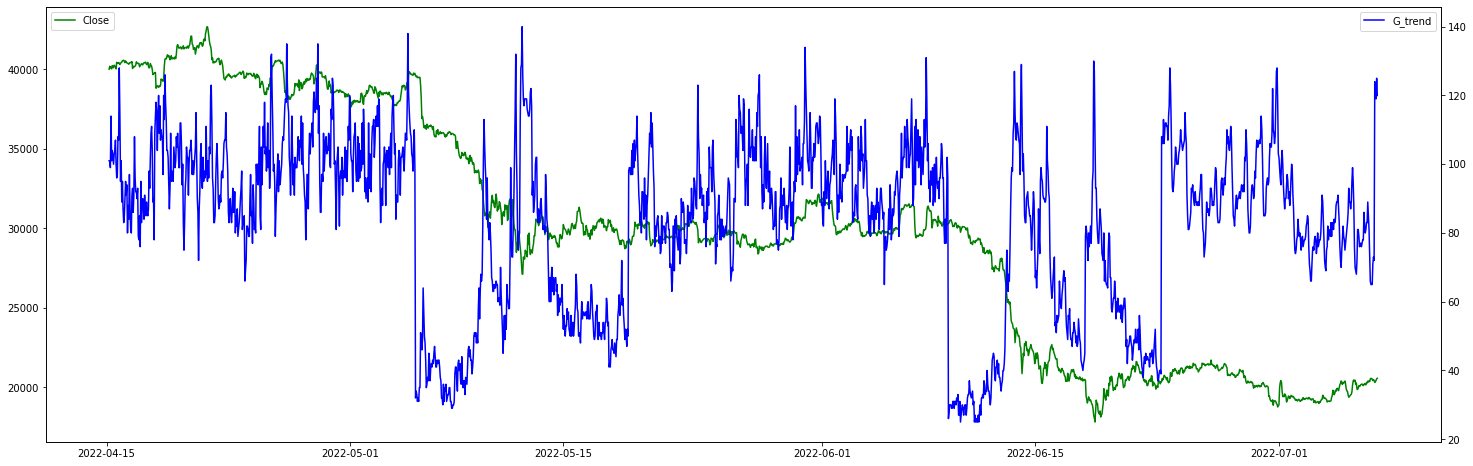

In [15]:
window_to_see = 2000
df_see = df_BTC.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.Close, color='green',label='Close')
ax = ax_left.twinx()
ax.plot(df_see.G_trend, color='blue',label='G_trend')
#ax.plot(df_see.FnG, color='orange',label='FnG')
ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

In [26]:
df_BTC = df_BTC.loc[df.index[0]:]
df['Open_BTC'] = df_BTC.Open
df['High_BTC'] = df_BTC.High
df['Low_BTC'] = df_BTC.Low
df['Close_BTC'] = df_BTC.Close
df['Volume_BTC'] = df_BTC.Volume
df = computeLaggingLinearRegression(df,window=15,filter_ceof=True, derivative=True,)
#df = computeFutureLinearRegression(df,window=15,filter_ceof=True, derivative=True,)
#df = computeTrixIndicator(df)
#df = addIndicators(df,derivative=True,double_derivative=True,b_engulfings=True)
#df = computeMASlope(df).dropna()
#df = computeRSI_VWAP(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,,,,,,
2017-08-17 22:00:00,301.60,309.40,299.01,304.79,272.42251,1503000000,4307.56,4354.84,4258.56,4346.74,48.975472,0.000013,0.000187,-0.000028
2017-08-17 23:00:00,304.79,309.40,304.04,307.44,330.54526,1503003600,4346.74,4369.69,4309.23,4333.55,61.773036,-0.000037,0.000156,-0.000031
2017-08-18 00:00:00,308.57,310.74,303.44,306.74,368.36785,1503007200,4333.55,4359.13,4310.00,4336.80,57.376142,-0.000074,0.000127,-0.000030
2017-08-18 01:00:00,306.74,310.85,302.00,302.00,229.60620,1503010800,4313.39,4337.38,4280.82,4285.08,81.645263,-0.000079,0.000095,-0.000032
2017-08-18 02:00:00,302.00,306.20,297.40,301.19,501.26558,1503014400,4285.08,4340.62,4228.76,4286.53,82.435474,-0.000110,0.000064,-0.000031


Period : [2021-12-10 12:00:00] -> [2022-07-06 20:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 39919.06 $
Performance vs US Dollar : 3891.91 %
Buy and Hold Performence : -72.03 %
Performance vs Buy and Hold : -5503.04 %
Best trade : +16.12 %, the 2022-06-19 20:00:00
Worst trade : -4.0 %, the 2022-05-11 14:00:00
Worst drawBack : -4.0 %
Total fees :  2808.85 $

----- Trades Informations -----
Total trades on period : 224
Number of positive trades : 170
Number of negative trades :  54
Trades win rate ratio : 75.89 %
Average trades performance : 1.77 %
Average positive trades : 2.63 %
Average negative trades : -0.95 %

----- Plot -----


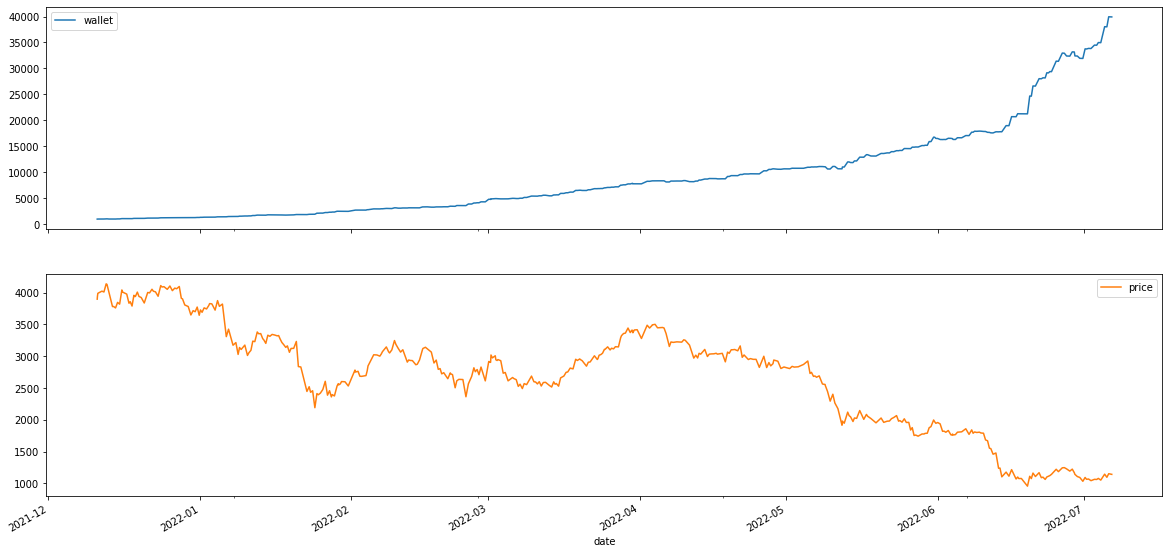

In [5]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.F_MLR_coefs_filtered_diff>0 and row.F_MLR_coefs_filtered_diff<0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.F_MLR_coefs_filtered_diff<0 and row.F_MLR_coefs_filtered_diff>0 else False

strategyTester(df.iloc[-5000:],buyCondition,sellCondition)

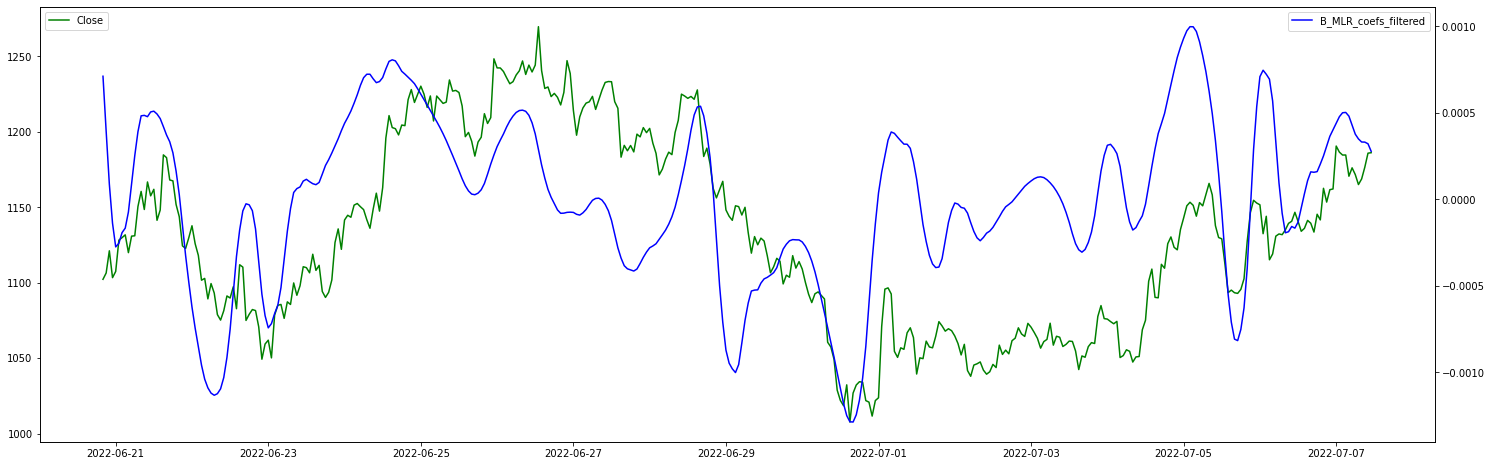

In [19]:
window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.Close, color='green',label='Close')
ax = ax_left.twinx()
ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
#ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

# Normalization

In [32]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'Open_BTC',
       'High_BTC', 'Low_BTC', 'Close_BTC', 'Volume_BTC', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'F_MLR_coefs', 'F_MLR_coefs_filtered',
       'F_MLR_coefs_filtered_diff', 'F_MLR_coefs_filtered_strat', 'Trix',
       'Trix_histo', 'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX',
       'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'EVM', 'Bullish_engulfing',
       'Bearish_engulfing', 'Slope', 'Acceleration', 'Angle', 'MA_Slope',
       'RSI_VWAP'],
      dtype='object')

In [33]:
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Open_BTC',
       'High_BTC', 'Low_BTC', 'Close_BTC', 'Volume_BTC', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'Trix',
       'Trix_histo', 'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX',
       'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'EVM', 'Bullish_engulfing',
       'Bearish_engulfing', 'Slope', 'Acceleration', 'Angle', 'MA_Slope',
       'RSI_VWAP']].values)

joblib.dump(x_scaler,f'./models/std_scaler_{SYMBOL}.save')

['./models/std_scaler_ETH.save']

# Decorrelation

In [ ]:
import seaborn as sb
corr = df.corr()
fig, ax = plt.subplots(1, figsize=(25,8))

sb.heatmap(corr, cmap="Blues", annot=True, ax=ax)

In [ ]:
from sklearn.decomposition import PCA

decomposer = PCA()
all_component_decorr = decomposer.fit_transform(x_scaled)

In [ ]:
var = decomposer.explained_variance_
var_ratio = decomposer.explained_variance_ratio_
var_ratio_cumcum = np.cumsum(var_ratio)
df_variances = pd.DataFrame(data={
    "Variance":var,
    "Variance_ratio":var_ratio,
    "Variance_ratio_cum":var_ratio_cumcum
},index=[i for i in ['Open', 'High', 'Low', 'Close', 'Volume',  'High_Low_diff', 'EMA20', 'EMA50', 'EMA100',
       'EMA200', 'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low',
       'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'TRIX','TRIX_HISTO', 'EVM']])
df_variances.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(25,10))

ax.plot(df_variances.Variance_ratio_cum,color='red')
ax.axhline(y=0.99,linestyle='--',color='black')
ax_2 = ax.twinx()
ax_2.hist(df_variances.Variance,alpha=0.4)

We need only 8 components to use the dataset with 95% variance

In [ ]:
decorrelator = PCA(n_components=11)
useful_component_decorr = decorrelator.fit_transform(x_scaled)
useful_component_decorr

# Predictions

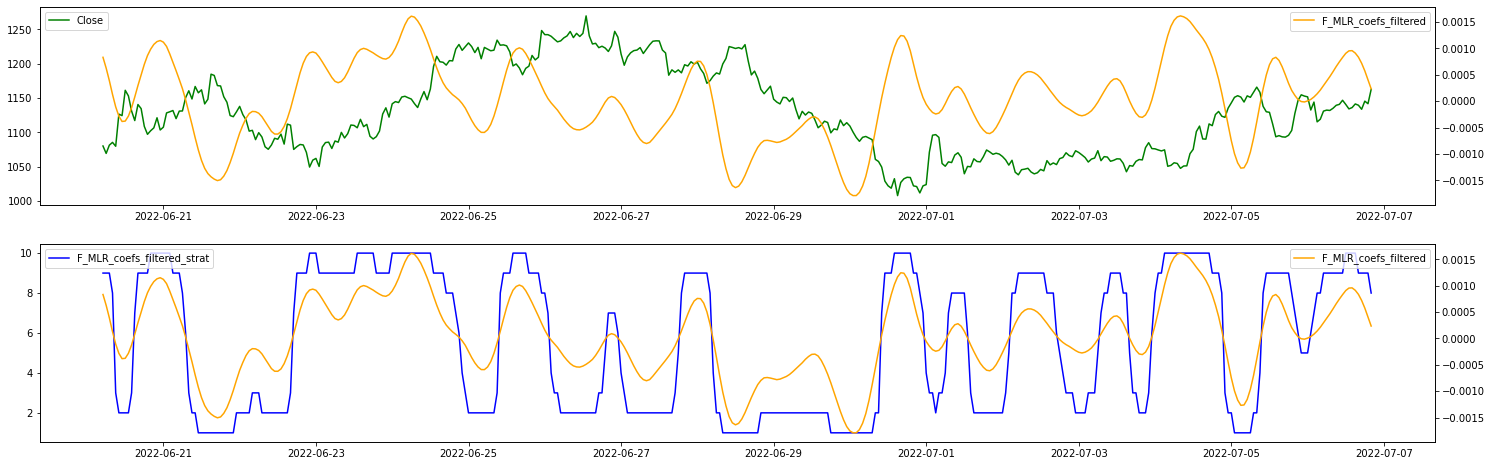

In [34]:
window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(2, figsize=(25,8))

ax_left[0].plot(df_see.Close, color='green',label='Close')
ax = ax_left[0].twinx()
#ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[0].legend(loc="upper left")
ax.legend(loc="upper right")
ax_left[1].plot(df_see.F_MLR_coefs_filtered_strat, color='blue',label='F_MLR_coefs_filtered_strat')
ax = ax_left[1].twinx()
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[1].legend(loc="upper left")
ax.legend(loc="upper right")

## Classification

### Bins Classficiation

In [6]:
WINDOW=20

X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn
y_clf = np.array([df.F_MLR_coefs_filtered_strat.iloc[i] for i in range(WINDOW,len(df))]) #Classification

X_train, X_test, y_train, y_test = train_test_split(X,y_clf,test_size=0.2, shuffle=True)

In [ ]:
model = RandomForestClassifier(n_estimators=120,criterion='entropy',verbose=1,n_jobs=4)
model.fit(X_train,y_train)

joblib.dump(model, f"./models/random_forect_clf_1h_{SYMBOL}.save")

In [ ]:
y_clf_pred = model.predict(X)
print(model.score(X_test,y_test))

## Regression

In [35]:
WINDOW=20

X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn
X_tf = np.array([x_scaled[i-WINDOW:i] for i in range(WINDOW,len(x_scaled))]) # Tensorflow
#X = np.array([useful_component_decorr[i:i+WINDOW].reshape(1,-1)[0] for i in range(len(useful_component_decorr)-WINDOW)]) # Sklearn + PCA 8

y_reg = MinMaxScaler((-1,1)).fit_transform(np.array([df.F_MLR_coefs_filtered.iloc[i] for i in range(WINDOW,len(df))]).reshape(-1, 1)) #Regression

X_train, X_test, y_train, y_test = train_test_split(X,y_reg,test_size=0.2, shuffle=True)

In [ ]:
model = RandomForestRegressor(verbose=1,n_jobs=4)
model.fit(X_train,y_train)
joblib.dump(model, f"./models/random_forect_reg_1h_{SYMBOL}.save") 

In [ ]:
y_reg_pred = model.predict(X)
print(model.score(X_test,y_test))

## Correction

In [34]:
reg= joblib.load('./models/random_forest_reg_1h_all_8_cpu.save')
y_reg_pred = reg.predict(X)
clf = joblib.load('./models/random_forest_clf_1h_all_8_cpu.save')
y_clf_pred = clf.predict(X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    1.3s finished


In [9]:
import tensorflow as tf
from tensorflow import keras


2022-06-24 12:06:10.702383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 12:06:10.702547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
new_model = tf.keras.models.load_model('./models/lstm_conv_dense_all.h5')
y_nn_pred = new_model.predict(X_tf)
y_nn_pred

array([[ 0.07059038],
       [ 0.06726287],
       [ 0.06614101],
       ...,
       [-0.01079955],
       [-0.00267027],
       [-0.00100728]], dtype=float32)

In [36]:
model = RandomForestRegressor(verbose=1,n_jobs=4)
model.fit(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1),y_reg)
print(model.score(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1),y_reg))
y_f = model.predict(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.8661749467188621


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


In [ ]:
joblib.dump(model, f"./models/random_forect_corrector_1h_{SYMBOL}.save") 

In [37]:
df['y_final'] = np.nan
df['y_final'].iloc[WINDOW:]=y_f
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Timestamp,Open_BTC,High_BTC,Low_BTC,Close_BTC,...,OVB_EMA200,EVM,Bullish_engulfing,Bearish_engulfing,Slope,Acceleration,Angle,MA_Slope,RSI_VWAP,y_final
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30 06:00:00,28.000,29.430,27.921,29.056,28235.764,1604034000,13420.87,13497.74,13174.52,13181.57,...,-110715.080837,3230.620925,0.0,0.0,1.066,0.887,38.0,24.408442,0.000000,0.192723
2020-10-30 07:00:00,29.068,29.634,29.047,29.105,5243.838,1604037600,13181.56,13293.80,13146.48,13201.99,...,-111932.343983,7444.070545,0.0,0.0,0.049,-1.017,41.0,24.501341,0.000000,0.188155
2020-10-30 08:00:00,29.105,29.318,28.608,29.120,7126.446,1604041200,13201.99,13261.22,13115.00,13218.96,...,-113066.585148,-3760.991103,0.0,0.0,0.015,-0.034,40.0,24.586970,0.000000,0.186425
2020-10-30 09:00:00,29.182,30.943,28.996,29.795,11630.859,1604044800,13218.96,13338.85,13188.91,13242.48,...,-114073.810390,16848.759838,0.0,0.0,0.675,0.660,42.0,24.699966,0.674141,0.185827
2020-10-30 10:00:00,29.751,30.087,28.955,29.727,11436.222,1604048400,13242.49,13298.43,13147.66,13277.05,...,-115184.806744,-4439.420641,0.0,0.0,-0.068,-0.743,44.0,24.795736,0.661641,0.180648


In [36]:
X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn

reg = joblib.load('./models/random_forest_reg_1h_all.save')
y_reg_pred = reg.predict(X)
clf = joblib.load('./models/random_forest_clf_1h_all.save')
y_clf_pred = clf.predict(X)
corrector = joblib.load('./models/random_forest_corrector_1h_ETH.save')
y_final = corrector.predict(np.stack((y_clf_pred,y_reg_pred),axis=1))

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 120 out of 120 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [37]:
df['y_final'] = np.nan
df['y_final'].iloc[WINDOW:]=y_final
df = df.dropna()

df['y_final_filtered'] = np.nan 
df['y_final_filtered'] = savgol_filter(df.y_final,15,2,mode='nearest')
df['y_final_filtered_diff']  = df['y_final_filtered'].diff(2)

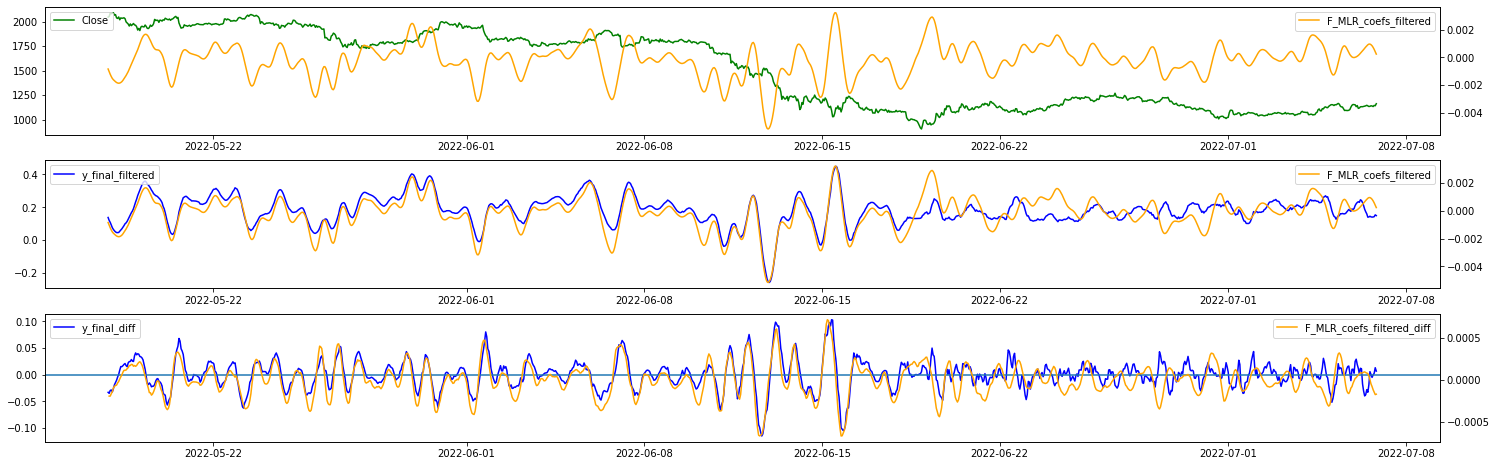

In [40]:
window_to_see = 1200
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(3, figsize=(25,8))

ax_left[0].plot(df_see.Close, color='green',label='Close')
ax = ax_left[0].twinx()
#ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[0].legend(loc="upper left")
ax.legend(loc="upper right")
ax_left[1].plot(df_see.y_final_filtered, color='blue',label='y_final_filtered')
ax = ax_left[1].twinx()
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[1].legend(loc="upper left")
ax.legend(loc="upper right")

ax_left[2].plot(df_see.y_final_filtered_diff, color='blue',label='y_final_diff')
ax = ax_left[2].twinx()
ax.plot(df_see.F_MLR_coefs_filtered.diff(), color='orange',label='F_MLR_coefs_filtered_diff')
ax_left[2].axhline(y=0)
ax_left[2].legend(loc="upper left")
ax.legend(loc="upper right")

Period : [2021-12-10 12:00:00] -> [2022-07-06 20:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 19492.91 $
Performance vs US Dollar : 1849.29 %
Buy and Hold Performence : -72.03 %
Performance vs Buy and Hold : -2667.33 %
Best trade : +10.63 %, the 2022-03-01 07:00:00
Worst trade : -5.42 %, the 2022-06-28 21:00:00
Worst drawBack : -14.000000000000002 %
Total fees :  3084.19 $

----- Trades Informations -----
Total trades on period : 255
Number of positive trades : 191
Number of negative trades :  64
Trades win rate ratio : 74.9 %
Average trades performance : 1.27 %
Average positive trades : 2.13 %
Average negative trades : -1.28 %

----- Plot -----


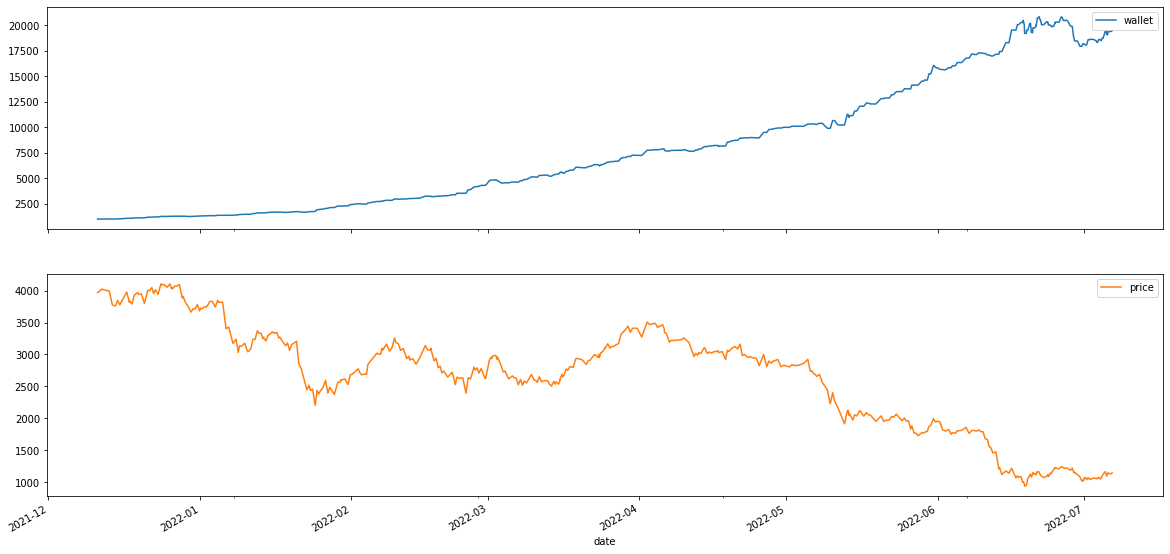

In [39]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.y_final_filtered_diff>0 and row.y_final_filtered_diff<0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.y_final_filtered_diff<0 and row.y_final_filtered_diff>0 else False

strategyTester(df.iloc[-5000:],buyCondition,sellCondition)